**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import PIL
import Augmentor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This data conatains about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## Importing Skinn Cancer Datasets

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## creating the train dataset using image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## creating the validation dataset using image_dataset_from_directory
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Listing out all the classes of skin cancer and store them in a list..
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [ ]:
import matplotlib.pyplot as plt
# Initialize a dictionary to store one image per class
class_images = {}

# Iterate through the dataset and capture one image for each class
for images, labels in train_ds:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if class_name not in class_images:  # Only save one instance per class
            class_images[class_name] = image.numpy()
        if len(class_images) == len(class_names):  # Break if all classes are covered
            break
    if len(class_images) == len(class_names):
        break

### your code goes here, you can use training or validation data to visualize

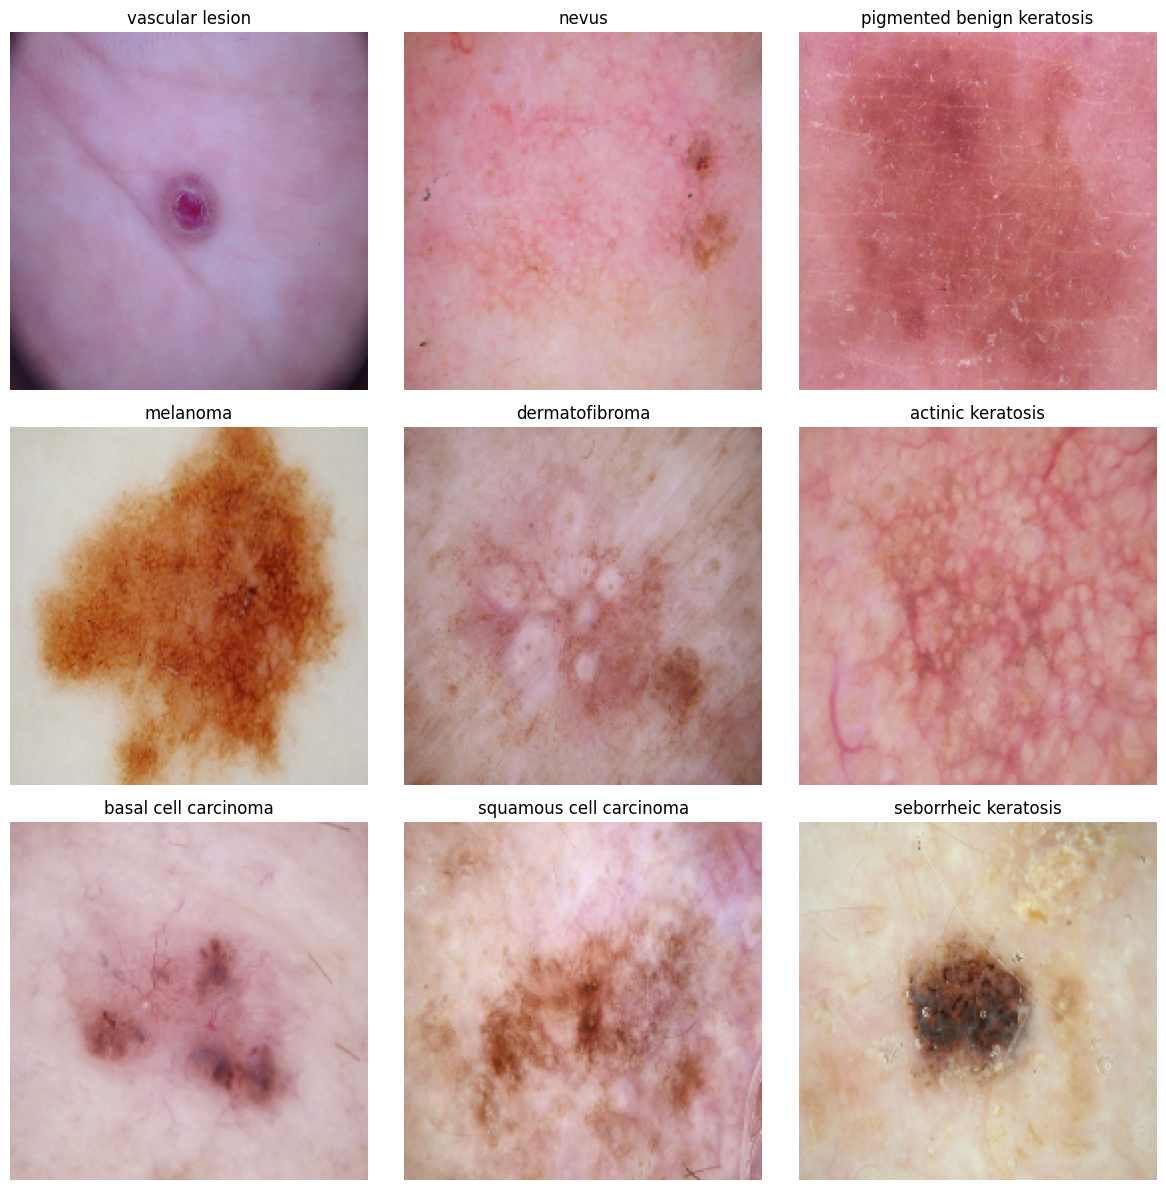

In [ ]:
# Plot one image per class
plt.figure(figsize=(12, 12))
for idx, (class_name, image) in enumerate(class_images.items()):
    plt.subplot(3, 3, idx + 1)  # Assuming there are 9 classes
    plt.imshow(image.astype('uint8'))  # Ensure correct type for visualization
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [ ]:
image_batch, label_batch = next(iter(train_ds))
print(image_batch.shape)
print(label_batch.shape)

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## CNN Model 1 (Simple Architecture)

### Create the model


In [ ]:
# Define the CNN model
model = tf.keras.Sequential([
    layers.Rescaling(1./125, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # Output layer for 9 classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Optimiser : *Adam*

Loss Function: *Categorical Cross Entropy*

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss=keras.losses.SparseCategoricalCrossentropy,
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,276,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,301,673 (12.59 MB)

 Trainable params: 3,301,673 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 760s 4s/step - accuracy: 0.1747 - loss: 2.6279 - val_accuracy: 0.2774 - val_loss: 2.0384
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - accuracy: 0.2543 - loss: 2.0022 - val_accuracy: 0.2975 - val_loss: 1.8586
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3649 - loss: 1.7729 - val_accuracy: 0.4989 - val_loss: 1.4844
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4809 - loss: 1.5028 - val_accuracy: 0.4519 - val_loss: 1.6149
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4801 - loss: 1.5082 - val_accuracy: 0.4541 - val_loss: 1.5233
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4991 - loss: 1.3905 - val_accuracy: 0.5123 - val_loss: 1.5896
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5382 - loss: 1.3241 - val_accuracy: 0.4027 - val_loss: 1.7398
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5291 - loss: 1.2955 - val_accuracy: 0.5257 - 

### Visualizing training results

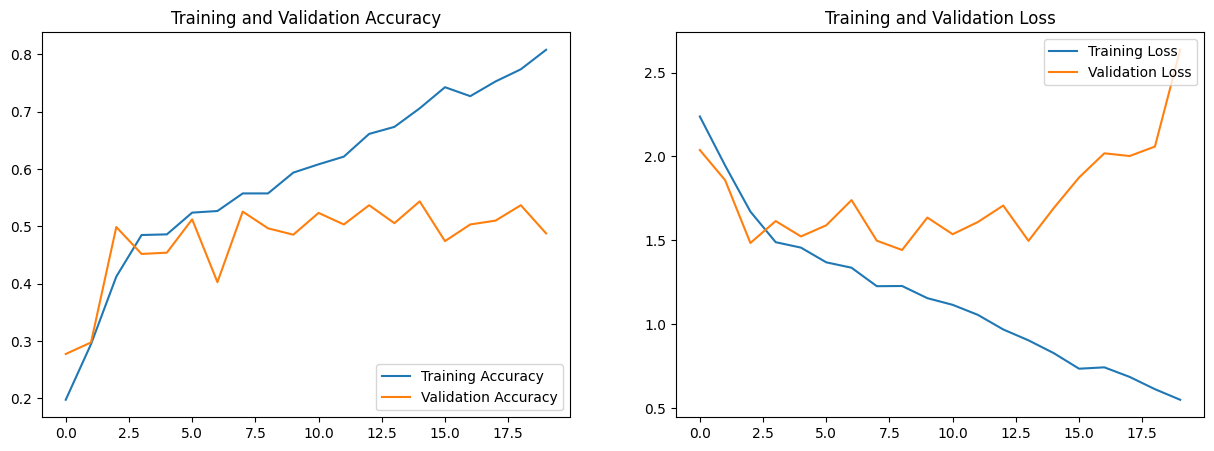

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings from the first model run


1.   This suggests the model is overfitting to the training data. While the model performs well on the training set, it fails to generalize to the validation data
2.   The increasing validation loss alongside decreasing training loss is a hallmark of overfitting. The model memorizes the training data but struggles with unseen data



## Augmentation Example

In [ ]:
# Extract a single image from the training dataset
for image, label in train_ds.take(1):  # Take a single batch
    original_image = image[0]  # Get the first image in the batch
    break

#augmentation strategy
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

# Apply augmentation multiple times to the same image
augmented_images = [data_augmentation(tf.expand_dims(original_image, 0))[0] for _ in range(9)]

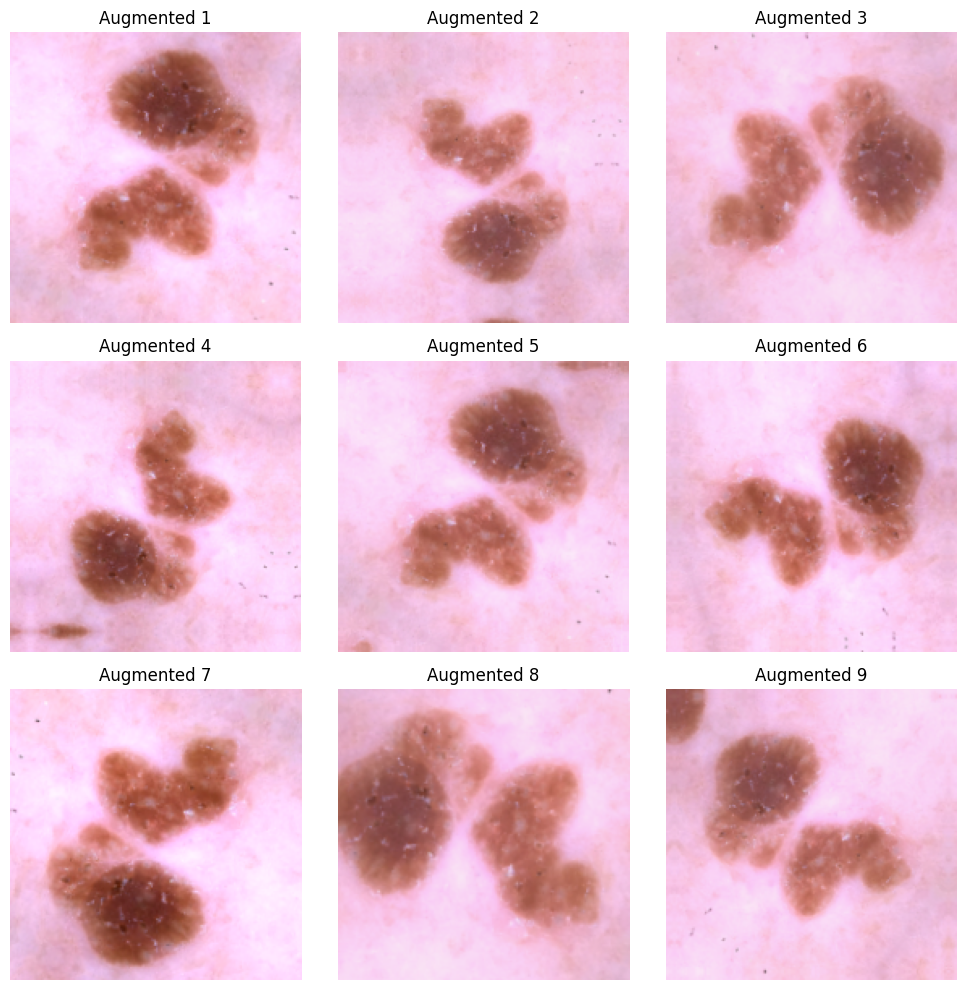

In [ ]:
# Plot the original and augmented images
plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.imshow(original_image.numpy().astype("uint8"))
plt.title("Original Image")
plt.axis("off")

for i, aug_img in enumerate(augmented_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(aug_img.numpy().astype("uint8"))
    plt.title(f"Augmented {i + 1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## CNN Model with augmentation and Drop out layers




### Model 2 (Augmentation)

In [ ]:
# Apply data augmentation to the training dataset using `tf.data` transformations
augmented_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

aug_train_ds = augmented_datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=123
)

aug_val_ds = augmented_datagen.flow_from_directory(
    data_dir_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=123
)

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [31]:
#improving the prallelized computing across the autotune functionality
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Define the CNN model
model = tf.keras.Sequential([
    layers.Rescaling(1./125, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # Output layer for 9 classes
])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,276,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,301,673 (12.59 MB)

 Trainable params: 3,301,673 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the Model

In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Training the Model

In [ ]:
epochs = 20
history = model.fit(
  aug_train_ds,
  validation_data=aug_val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 731ms/step - accuracy: 0.1762 - loss: 2.5029 - val_accuracy: 0.2680 - val_loss: 1.8788
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 77s 682ms/step - accuracy: 0.2846 - loss: 1.9085 - val_accuracy: 0.2230 - val_loss: 1.9632
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 682ms/step - accuracy: 0.3223 - loss: 1.8401 - val_accuracy: 0.3176 - val_loss: 2.0901
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 84s 691ms/step - accuracy: 0.3965 - loss: 1.7184 - val_accuracy: 0.3581 - val_loss: 1.8022
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 685ms/step - accuracy: 0.4166 - loss: 1.6329 - val_accuracy: 0.3941 - val_loss: 1.8140
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 672ms/step - accuracy: 0.4920 - loss: 1.5058 - val_accuracy: 0.3896 - val_loss: 1.8194
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 681ms/step - accuracy: 0.4804 - loss: 1.4909 - val_accuracy: 0.3626 - val_loss: 1.7545
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 83s 704ms/step - accuracy: 0.4932 - loss: 1.4402 - val_accuracy: 0.373

#### Visualizing the results

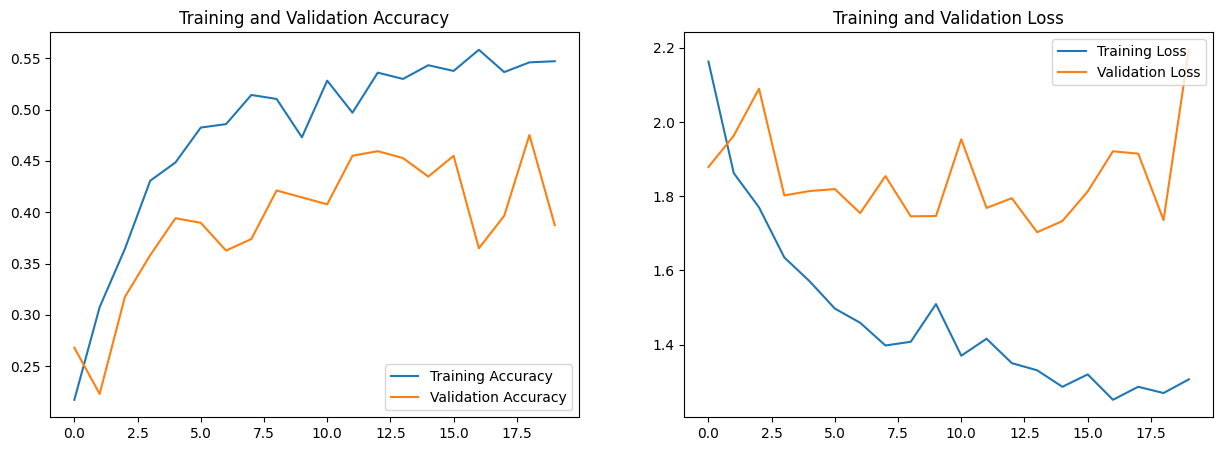

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Findings:**

Plot shows the model is improving in generalization compared to the earlier run
but is still underperforming on validation data compared to training. The gap indicates slight overfitting or a limitation in the model's ability to generalize

The validation loss behavior indicates that overfitting is still present, though reduced compared to the first run. This could also hint at potential room for better data augmentation or regularization techniques


### Model 3 (Augmentation + Dropout Layer)


In [65]:
## Adding Dropout layer
# Define the CNN model
model = tf.keras.Sequential([
    layers.Rescaling(1./125, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(9, activation='softmax')  # Output layer for 9 classes
])

model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       3,276,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,301,673 (12.59 MB)

 Trainable params: 3,301,673 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the model

In [66]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Training the model

In [67]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(aug_train_ds, validation_data=aug_val_ds, epochs=epochs)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 936ms/step - accuracy: 0.1974 - loss: 2.6336 - val_accuracy: 0.3333 - val_loss: 1.8801
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 67s 709ms/step - accuracy: 0.3821 - loss: 1.7301 - val_accuracy: 0.2905 - val_loss: 1.8328
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 83s 710ms/step - accuracy: 0.4092 - loss: 1.6744 - val_accuracy: 0.3131 - val_loss: 1.8066
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 79s 682ms/step - accuracy: 0.3890 - loss: 1.6550 - val_accuracy: 0.3423 - val_loss: 1.7688
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 86s 749ms/step - accuracy: 0.4281 - loss: 1.6065 - val_accuracy: 0.3266 - val_loss: 1.8608
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 48s 756ms/step - accuracy: 0.4397 - loss: 1.5621 - val_accuracy: 0.3941 - val_loss: 1.8404
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 80s 727ms/step - accuracy: 0.4369 - loss: 1.5544 - val_accuracy: 0.3536 - val_loss: 1.8946
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 79s 682ms/step - accuracy: 0.4393 - loss: 1.4993 - val_accu

#### Visualizing the results

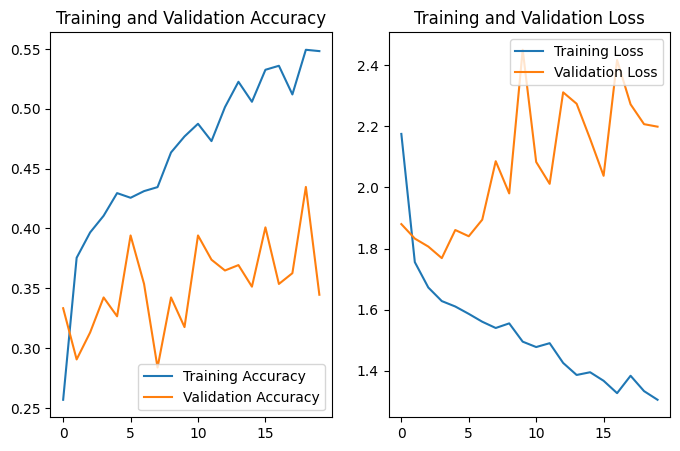

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,5 ))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Findings**

Training accuracy improves steadily, but validation accuracy fluctuates significantly and remains lower. This suggests that the model is overfitting the training data and struggling to generalize to unseen data

 Behavior of validation loss, combined with its consistently higher value compared to training loss, indicates potential issues with
Data quality (e.g., class imbalance, noisy samples)

## Handling Class Imbalance

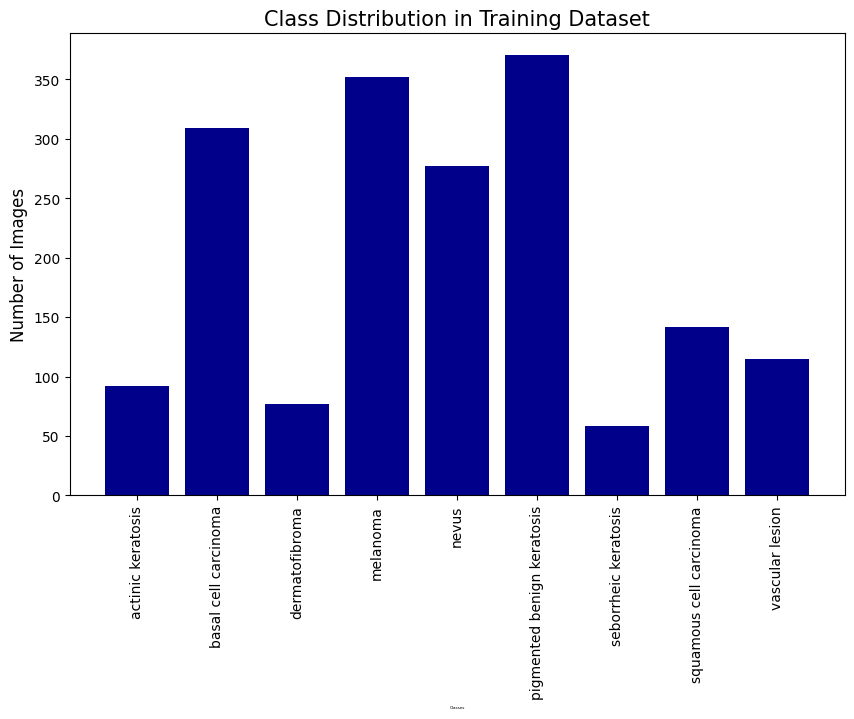

In [32]:
# Visualizing the class imbalance

# Get class names
#class_names = train_ds.class_names

# Initialize a dictionary to store counts
class_counts = {class_name: 0 for class_name in class_names}

# Count occurrences of each class in the training dataset
for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

# Prepare data for plotting
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='darkblue')
plt.xlabel('Classes', fontsize=3)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Class Distribution in Training Dataset', fontsize=15)
plt.xticks(rotation=90)
plt.show()


#### **Findings here**
- Which class has the least number of samples?

  Ans: seborrheic keratosis with 77 samples

- Which classes dominate the data in terms proportionate number of samples?
  
  Ans: Pigmented benign keratosis, Melanoma, basal Cell Carcinoma


In [34]:
!pip install Augmentor

In [35]:
#using Augmentation technique to generate sample data to treat imbalance
path_to_training_dataset=pathlib.Path(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ECD52137A90>: 100%|██████████| 500/500 [00:20<00:00, 24.38 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ECD3CFC2B90>: 100%|██████████| 500/500 [00:20<00:00, 24.85 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7ECD46912B00>: 100%|██████████| 500/500 [00:21<00:00, 23.41 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7ECD3D7B6140>: 100%|██████████| 500/500 [01:43<00:00,  4.82 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ECDB0315900>: 100%|██████████| 500/500 [01:14<00:00,  6.74 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ECDB0388220>: 100%|██████████| 500/500 [00:21<00:00, 23.04 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7ECD468BD240>: 100%|██████████| 500/500 [00:40<00:00, 12.21 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ECD3D7E1960>: 100%|██████████| 500/500 [00:20<00:00, 24.55 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7ECD46AA1C90>: 100%|██████████| 500/500 [00:20<00:00, 24.53 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Distribution after adding augmented data

In [37]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

#converting into DataFrame
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['Label'].value_counts().reset_index()

,Label,count
0,nevus,500
1,basal cell carcinoma,500
2,melanoma,500
3,actinic keratosis,500
4,seborrheic keratosis,500
5,squamous cell carcinoma,500
6,dermatofibroma,500
7,vascular lesion,500
8,pigmented benign keratosis,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [39]:
data_dir_train=pathlib.Path(data_dir_train)
augt_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Creating  validation dataset

In [40]:
augt_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [44]:
augt_train_ds = augt_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
augt_val_ds = augt_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Final Model (Augmented Data)**




In [59]:
model = tf.keras.Sequential([
    layers.Rescaling(1./125, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(9, activation='softmax')])  # Output layer for 9 classes

#Model Summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       3,276,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,301,673 (12.59 MB)

 Trainable params: 3,301,673 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

#### Compiling the model


In [60]:
#compiling the final Model
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

 #### Model Training

In [61]:
epochs = 40 # using 40 epochs.
history = model.fit(
  augt_train_ds,
  validation_data=augt_val_ds,
  epochs=epochs
)

Epoch 1/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.1982 - loss: 2.2018 - val_accuracy: 0.3667 - val_loss: 1.7065
Epoch 2/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3864 - loss: 1.6031 - val_accuracy: 0.3868 - val_loss: 1.5915
Epoch 3/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4181 - loss: 1.4940 - val_accuracy: 0.4581 - val_loss: 1.4145
Epoch 4/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.4573 - loss: 1.4029 - val_accuracy: 0.5108 - val_loss: 1.3083
Epoch 5/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4783 - loss: 1.3470 - val_accuracy: 0.5286 - val_loss: 1.2634
Epoch 6/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5151 - loss: 1.2629 - val_accuracy: 0.5612 - val_loss: 1.2112
Epoch 7/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5339 - loss: 1.2014 - val_accuracy: 0.5590 - val_loss: 1.1569
Epoch 8/40
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5656 - loss: 1.1182 - val_acc

####  Visualizing the model results

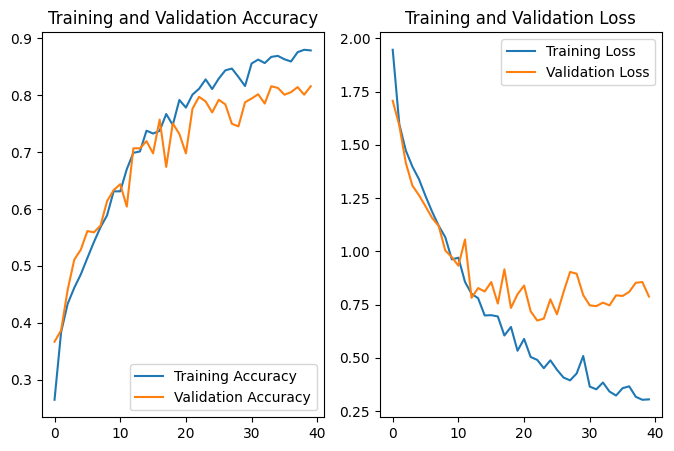

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Findings:**

*   The consistent improvement in validation accuracy and the close alignment with training accuracy suggest that class rebalancing via augmentation has had a positive impact.

*   Validation accuracy improves consistently and closely tracks the training accuracy, suggesting good generalization
*   The validation loss shows some fluctuations after about 10 epochs but does not diverge significantly from the training loss. This indicates overfitting is minimal or well-controlled
